This book reproduces the results on the D desorption from W laser heating. The results on the estimation of the atomic fraction in the desorption flux are presented in [V.Kulagin et al. FusDes 2022](https://www.sciencedirect.com/science/article/pii/S0920379622002794) and [V.Kulagin et al. J. Surf. Investig.  2022](https://link.springer.com/article/10.1134/S1027451022050317). The results about the effect on material properties on the LID efficiency are published in [V.Kulagin et al. JNM 2023](https://www.sciencedirect.com/science/article/pii/S0022311523005147). 

The raw data is too heavy for Git, so it is distributed via Zenodo. To use this book, one should provide an appropriate PATH to the data in the archive. All the scripts can be found within the parent folder. An example on how to run a series of simulations is provided in the "Specific simulations for LID regimes figure" cell.

In [1]:
path = "/mnt/X/PhD_data/LID/"

## Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sub_functions.materials import W
from model import LID_simulation
from festim import k_B
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
            r"\usepackage{upgreek}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54


def integrate_flux(t, F):
    return np.trapz(F, x=t)


def get_maxs(data):
    data = np.array(data)
    maxs = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        maxs[i] = data[:, i].max()
    return maxs


def get_mins(data):
    data = np.array(data)
    mins = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        mins[i] = data[:, i].min()
    return mins

/home/vvkulagin/anaconda3/envs/PhD-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Laser pulses

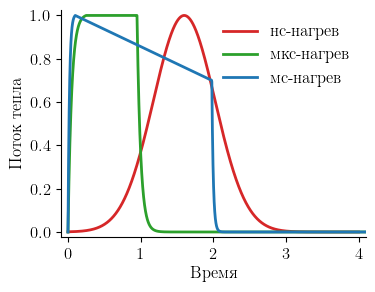

In [3]:
def gauss_heat(t, t0, FWHM):
    sigma = FWHM / 2 / np.sqrt(2 * np.log(2))  # standard deviation, s
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-((t - t0) ** 2) / 2 / sigma**2)


def trapezoid_heat(t, t1, t2, delta, tau_le, tau_te):
    f1 = lambda t: 1 - np.exp(-t / tau_le)
    f2 = lambda t: f1(t1) * (1 + delta * (t - t1) / (t2 - t1))
    shape = lambda t: np.piecewise(
        t,
        [t <= t1, (t > t1) & (t <= t2), t > t2],
        [
            lambda t: 1 - np.exp(-t / tau_le),
            lambda t: (1 - np.exp(-t1 / tau_le)) * (1 + delta * (t - t1) / (t2 - t1)),
            lambda t: (1 - np.exp(-t1 / tau_le))
            * (1 + delta)
            * np.exp(-(t - t2) / tau_te),
        ],
    )
    norm = (
        t1
        + tau_le * (np.exp(-t1 / tau_le) - 1)
        + f1(t1) * (t2 - t1) * (1 - delta / 2)
        + f2(t2) * tau_te
    )
    return shape(t) / norm


us_params = [2.5e-6, 9.5e-6, 0, 0.5e-6, 0.5e-6]
ms_params = [0.25e-3, 4.95e-3, -0.3, 0.05e-3, 0.05e-3]
t_norm = np.linspace(0, 100, num=10000)

plt.figure(figsize=(100 * mm2inch, 75 * mm2inch))

plt.plot(
    t_norm / 25,
    gauss_heat(t_norm * 1e-9, 40e-9, 25e-9)
    / max(gauss_heat(t_norm * 1e-9, 40e-9, 25e-9)),
    lw=2,
    color="tab:red",
    label="нс-нагрев",
)
plt.plot(
    t_norm / 10,
    trapezoid_heat(t_norm * 1e-6, *us_params)
    / max(trapezoid_heat(t_norm * 1e-6, *us_params)),
    lw=2,
    color="tab:green",
    label="мкс-нагрев",
)
plt.plot(
    t_norm / 2.5,
    trapezoid_heat(t_norm * 1e-3, *ms_params)
    / max(trapezoid_heat(t_norm * 1e-3, *ms_params)),
    lw=2,
    color="tab:blue",
    label="мс-нагрев",
)

plt.ylim(-0.025, 1.025)
plt.xlim(-0.1, 4.1)
plt.legend()
plt.ylabel("Поток тепла")
plt.xlabel("Время")

plt.savefig(
    "../../../Thesis/images/laser_time_profiles.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Atomic fraction

In [4]:
mat = W()

Q_c = lambda cs: mat.Q_c(cs)
E_c = mat.E_c
Q_s = mat.Q_s
E_s = mat.E_s
E_d = mat.E_d
n_surf = mat.n_surf


def K_bs(T):
    return mat.nu_D / mat.nu_0 * np.exp(-(E_s - Q_s) / k_B / T)


def K_sb(T, cs):
    return np.exp(-(E_s - Q_c(cs)) / k_B / T)


def K_m_s(T, cs):
    return np.exp(-2 * (E_c - Q_c(cs)) / k_B / T)


def K_m_sb(T, cs):
    return mat.nu_D / mat.nu_0 * np.exp(-((E_c - Q_c(cs) + E_s - Q_s)) / k_B / T)


def K_m_b(T):
    return mat.nu_D / mat.nu_0 * np.exp(-2 * (E_s - Q_s) / k_B / T)


def K_a(T, cs):
    return np.exp(-(E_d - Q_c(cs)) / k_B / T)


def equations(vars, F, T):
    x, y = vars
    cs = x * n_surf

    eq1 = (
        y * (1 - x) * K_bs(T)
        - x * (1 - y) * K_sb(T, cs)
        + 2 * y**2 * K_m_b(T)
        + x * y * K_m_sb(T, cs)
        - F
    )
    eq2 = (
        y * (1 - x) * K_bs(T)
        - x * (1 - y) * K_sb(T, cs)
        - 2 * x**2 * K_m_s(T, cs)
        - x * y * K_m_sb(T, cs)
        - x * K_a(T, cs)
    )

    return [eq1, eq2]


temp = np.linspace(500, 4000, num=100, endpoint=True)
flux = np.logspace(16, 28, num=100, endpoint=True)

F, T = np.meshgrid(flux, temp)

theta = np.zeros_like(T)
beta = np.zeros_like(T)

initial_guess = [0.1, 0.95]

for i in range(len(F)):
    for j in range(len(F[0])):
        solution = fsolve(
            equations, initial_guess, args=(F[i][j] / 1e13 / n_surf, T[i][j])
        )

        theta[i][j] = solution[0]
        beta[i][j] = solution[1]

In [5]:
def AtFr_analytical(T, F):
    J0 = mat.nu_0 * mat.n_surf
    F_norm = F / J0

    return (
        K_a(T, 0) ** 2
        / 4
        / F_norm
        / K_m_s(T, 0)
        * (np.sqrt(1 + 8 * F_norm * K_m_s(T, 0) / K_a(T, 0) ** 2) - 1)
    )


def theta_analytical(T, F):
    J0 = mat.nu_0 * mat.n_surf
    F_norm = F / J0

    return (
        K_a(T, 0)
        / 4
        / K_m_s(T, 0)
        * (np.sqrt(1 + 8 * F_norm * K_m_s(T, 0) / K_a(T, 0) ** 2) - 1)
    )

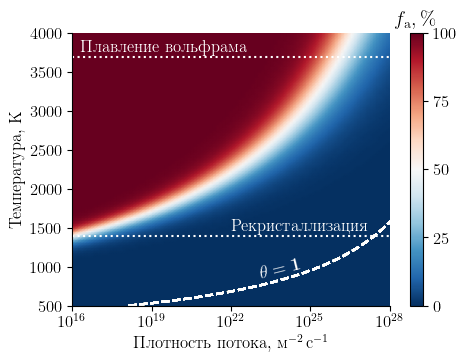

In [6]:
fig, ax = plt.subplots(figsize=(130 * mm2inch, 90 * mm2inch))

Ja = theta * n_surf * mat.nu_0 * K_a(T, theta * n_surf)
fa = Ja / F * 100
J0 = mat.nu_0 * mat.n_surf
jj = J0 * (2 * K_m_s(T, 0) + K_a(T, 0))

fa_an = AtFr_analytical(T, F) * 100

cm = ax.pcolormesh(F, T, fa, cmap="RdBu_r", shading="gouraud", vmin=0, vmax=100)
cbar = plt.colorbar(cm, ax=ax, ticks=[0, 25, 50, 75, 100])
cbar.ax.set_title(r"$f_\mathrm{a}, \%$")

"""cf = ax.contour(F, T, fa_an, levels=[50], linestyles="solid", colors="black", linewidths=2)
ax.scatter(
    cf.get_paths()[0].vertices[::10,0], 
    cf.get_paths()[0].vertices[::10,1],
    marker="s",
    color="limegreen",
    zorder=2)"""

ax.plot(jj, T, ls="dashed", color="white")

ax.axhline(3695, color="white", ls="dotted")
# ax.axhline(2750, color="white", ls="dashed")
# ax.axhline(1650, color="white", ls="dashed")
ax.axhline(1400, color="white", ls="dotted")

ax.text(2e16, 3800, "Плавление вольфрама", ha="left", va="center", color="white")
ax.text(1e22, 1500, "Рекристаллизация", ha="left", va="center", color="white")
ax.text(
    1e23,
    970,
    r"$\mathbf{\theta=1}$",
    ha="left",
    va="center",
    color="white",
    rotation=14,
    fontsize=13,
)
# ax.text(2e16, 2850, "Кипение бериллия", ha="left", va="center", color="white")
# ax.text(1e23, 1750, "Плавление бериллия", ha="left", va="center", color="white")

ax.set_xscale("log")
ax.set_xlim(1e16, 1e28)
ax.set_ylim(500, 4000)
ax.set_xlabel(r"Плотность потока, $\text{м}^{-2}\,\text{с}^{-1}$")
ax.set_ylabel(r"Температура, К")

plt.savefig(
    "../../../Thesis/images/atomic_fraction_diagram.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Surface temperature and flux evotuions

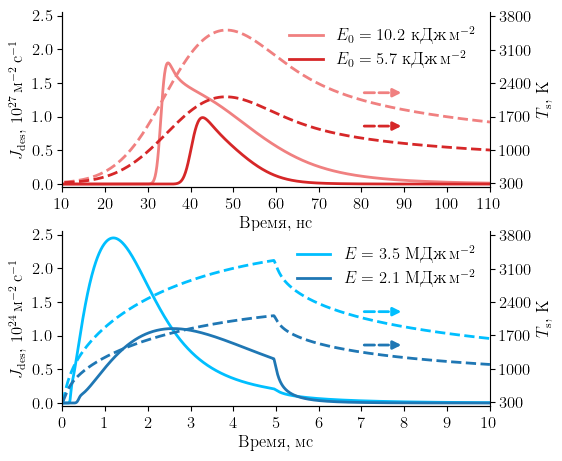

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(140 * mm2inch, 130 * mm2inch))
ax02 = axs[0].twinx()
ax12 = axs[1].twinx()

durations = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dt = 1.5
eta_tr = 1e-2
phi = 1
mat = "W"

colors = ["lightcoral", "tab:red"]
for i, k in enumerate([25, 14]):
    E = E_maxs[0] * k / 25
    my_model = LID_simulation(E, durations[0], mat, E_dt, eta_tr, phi, "", is_txt=False)

    filename = (
        path
        + f"Atomic_fraction/results/data_{mat}_{durations[0]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
    )
    results = np.loadtxt(fname=filename, skiprows=1, delimiter=",")

    t = np.array(results[:, 0])
    cs = np.array(results[:, 1])
    T = np.array(results[:, 3])
    cm = np.array(results[:, 4])

    Jat = my_model.J_a(T, cs)
    Jmol_s = my_model.J_m_s(T, cs)
    Jmol_sb = 2 * my_model.J_m_sb(T, cs, cm)
    Jmol_b = my_model.J_m_b(T, cm)

    J_des = Jat + Jmol_s + Jmol_sb + Jmol_b

    axs[0].plot(
        t / 1e-9,
        J_des / 1e27,
        lw=2,
        label=rf"$E_0={E/1e3:.1f}$ кДж$\,$м$^{{-2}}$",
        color=colors[i],
    )
    ax02.plot(t / 1e-9, T, ls="dashed", lw=2, color=colors[i])

for i, y in enumerate([2200, 1500]):
    ax02.annotate(
        "",
        xy=(87, y),
        xytext=(80, y),
        arrowprops=dict(arrowstyle="-", ls="dashed", lw=2, color=colors[i]),
    )
    ax02.annotate(
        "",
        xy=(90, y),
        xytext=(87, y),
        arrowprops=dict(arrowstyle="-|>", lw=2, color=colors[i]),
    )

axs[0].legend()
axs[0].set_xlim(10, 110)
axs[0].set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
axs[0].set_ylim(-0.05, 2.55)
axs[0].spines.right.set_visible(True)
ax02.set_ylim(300 - 3500 * 0.05 / 2, 3800 + 3500 * 0.05 / 2)
ax02.set_yticks([300, 1000, 1700, 2400, 3100, 3800])
ax02.set_ylabel(r"$T_\mathrm{s}$, К")
axs[0].set_ylabel(r"$J_\mathrm{des}$, $10^{27}\,$м$^{-2}\,$с$^{-1}$")
axs[0].set_xlabel("Время, нс")
axs[0].set_xlabel("Время, нс")

colors = ["deepskyblue", "tab:blue"]
for i, k in enumerate([23, 14]):
    E = E_maxs[2] * k / 25
    my_model = LID_simulation(E, durations[2], mat, E_dt, eta_tr, phi, "", is_txt=False)

    filename = (
        path
        + f"Atomic_fraction/results/data_{mat}_{durations[2]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
    )
    results = np.loadtxt(fname=filename, skiprows=1, delimiter=",")

    t = np.array(results[:, 0])
    cs = np.array(results[:, 1])
    T = np.array(results[:, 3])
    cm = np.array(results[:, 4])

    Jat = my_model.J_a(T, cs)
    Jmol_s = my_model.J_m_s(T, cs)
    Jmol_sb = 2 * my_model.J_m_sb(T, cs, cm)
    Jmol_b = my_model.J_m_b(T, cm)

    J_des = Jat + Jmol_s + Jmol_sb + Jmol_b

    axs[1].plot(
        t / 1e-3,
        J_des / 1e24,
        lw=2,
        label=rf"$E={E/1e6:.1f}$ МДж$\,$м$^{{-2}}$",
        color=colors[i],
    )
    ax12.plot(t / 1e-3, T, ls="dashed", lw=2, color=colors[i])

for i, y in enumerate([2200, 1500]):
    ax12.annotate(
        "",
        xy=(7.7, y),
        xytext=(7, y),
        arrowprops=dict(arrowstyle="-", ls="dashed", lw=2, color=colors[i]),
    )
    ax12.annotate(
        "",
        xy=(8, y),
        xytext=(7.7, y),
        arrowprops=dict(arrowstyle="-|>", lw=2, color=colors[i]),
    )

axs[1].legend()
axs[1].set_xlim(0, 10)
axs[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
axs[1].set_ylim(-0.05, 2.55)
axs[1].spines.right.set_visible(True)
ax12.set_ylim(300 - 3500 * 0.05 / 2, 3800 + 3500 * 0.05 / 2)
ax12.set_yticks([300, 1000, 1700, 2400, 3100, 3800])
axs[1].set_ylabel(r"$J_\mathrm{des}$, $10^{24}\,$м$^{-2}\,$с$^{-1}$")
ax12.set_ylabel(r"$T_\mathrm{s}$, К")
axs[1].set_xlabel("Время, мс")
axs[1].set_xlabel("Время, мс")
axs[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
axs[0].set_yticks([0, 0.5, 1, 1.5, 2, 2.5])


fig.subplots_adjust(hspace=0.25)
plt.savefig(
    "../../../Thesis/images/LID_flux_T_nsms.pdf", bbox_inches="tight", pad_inches=0.02
)

plt.show()

## Desorbed amount

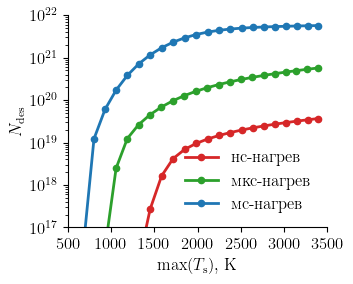

In [8]:
mat = "W"
durations = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.25, 1.5, 1.75, 2.0]
E_dt = 1.5

eta_trs = [1e-4, 1e-3, 1e-2, 1e-1]
eta_tr = 1e-2

phis = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
phi = 1

fig, ax = plt.subplots(figsize=(85 * mm2inch, 70 * mm2inch))


def integrate_flux(t, F):
    return np.trapz(F, x=t)


labels = ["нс-нагрев", "мкс-нагрев", "мс-нагрев"]
colors = ["tab:red", "tab:green", "tab:blue"]
for i in range(3):
    N_des = np.zeros(25)
    T_max = np.zeros(25)
    for j in range(1, 25):
        E = E_maxs[i] * j / 25

        filename_flux = (
            path
            + f"Atomic_fraction/results/fluxes_{mat}_{durations[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
        )
        filename_data = (
            path
            + f"Atomic_fraction/results/data_{mat}_{durations[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
        )
        fluxes = np.loadtxt(fname=filename_flux, skiprows=0, delimiter=",")
        results = np.loadtxt(fname=filename_data, skiprows=1, delimiter=",")

        T = results[:, 3]

        t = fluxes[:, 0]
        J_des = fluxes[:, 5]

        T_max[j] = T.max()
        N_des[j] = integrate_flux(t, J_des)

    ax.plot(T_max, N_des, marker="o", ms=4.5, color=colors[i], label=labels[i], lw=2)

ax.legend()
ax.set_yscale("log")
ax.set_ylim(1e17, 1e22)
ax.set_xlim(500, 3500)
ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000, 3500])
ax.set_ylabel(r"$N_\mathrm{des}$")
ax.set_xlabel(r"$\max(T_\mathrm{s})$, К")

plt.savefig(
    "../../../Thesis/images/LID_desorbed_amount.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Concentration profiles

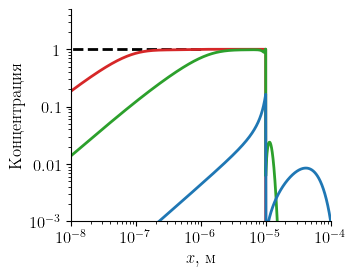

In [9]:
mat = "W"
durs = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.25, 1.5, 1.75, 2.0]
E_dt = 1.5

eta_trs = [1e-4, 1e-3, 1e-2, 1e-1]
eta_tr = 1e-2

phis = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
phi = 1

fig, ax = plt.subplots(figsize=(85 * mm2inch, 70 * mm2inch))

labels = ["нс-нагрев", "мкс-нагрев", "мс-нагрев"]
colors = ["tab:red", "tab:green", "tab:blue"]
ax.plot([0, 1e-6], [1, 1], ls="dashed", lw=2, color="black")
for i in range(3):
    E = E_maxs[i]
    name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

    filename_profile = (
        path + f"/Properties_effect/results_soret/ret_" + name_pattern + "_wSoret.txt"
    )
    profile = np.loadtxt(fname=filename_profile, skiprows=1, delimiter=",")

    ax.plot(
        profile[:, 0],
        profile[:, -1] / 1e-2 / 6.31e28,
        color=colors[i],
        label=labels[i],
        lw=2,
    )

# ax.legend(loc=(0.05, 0.85))
ax.set_yscale("log")
ax.set_ylim(1e-3, 5)
ax.set_xlim(0, 10)
ax.set_xscale("log")
ax.set_xlim(1e-8, 1e-4)
ax.set_ylabel(r"Концентрация")
ax.set_xlabel(r"$x$, м")
ax.set_yticks([1e-3, 1e-2, 0.1, 1])
ax.set_yticklabels([r"$10^{-3}$", r"$0.01$", r"$0.1$", r"$1$"])

plt.savefig(
    "../../../Thesis/images/LID_profiles.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Desorption fluxes

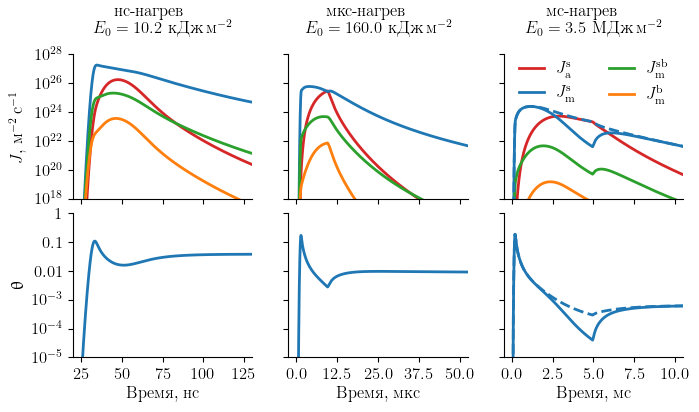

In [10]:
from model import LID_simulation
import numpy as np
import matplotlib.pyplot as plt
from sub_functions.materials import W

fig, ax = plt.subplots(
    2, 3, sharey="row", sharex="col", figsize=(200 * mm2inch, 100 * mm2inch)
)

durations = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.496e6]
E_dt = 1.5
eta_tr = 1e-2
phi = 1
mat = "W"
norm = [1e-9, 1e-6, 1e-3]
titles = [
    r"нс-нагрев\\$E_0=10.2$ кДж$\,$м$^{-2}$",
    r"мкс-нагрев\\$E_0=160.0$ кДж$\,$м$^{-2}$",
    r"мс-нагрев\\$E_0=3.5$ МДж$\,$м$^{-2}$",
]
for i in range(3):
    my_model = LID_simulation(
        E_maxs[i], durations[i], mat, E_dt, eta_tr, phi, "./results2", is_txt=False
    )

    filename = (
        path
        + f"Atomic_fraction/results/data_{mat}_{durations[i]}_E{E_maxs[i]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
    )
    results = np.loadtxt(fname=filename, skiprows=1, delimiter=",")

    t = np.array(results[:, 0])
    cs = np.array(results[:, 1])
    T = np.array(results[:, 3])
    cm = np.array(results[:, 4])

    Jat = my_model.J_a(T, cs)
    Jmol_s = my_model.J_m_s(T, cs)
    Jmol_sb = 2 * my_model.J_m_sb(T, cs, cm)
    Jmol_b = my_model.J_m_b(T, cm)

    ax[0][i].plot(
        t / norm[i], Jat, label=r"$J_\mathrm{a}^\mathrm{s}$", color="tab:red", lw=2
    )
    ax[0][i].plot(
        t / norm[i], Jmol_s, label=r"$J_\mathrm{m}^\mathrm{s}$", color="tab:blue", lw=2
    )
    ax[0][i].plot(
        t / norm[i],
        Jmol_sb,
        label=r"$J_\mathrm{m}^\mathrm{sb}$",
        color="tab:green",
        lw=2,
    )
    ax[0][i].plot(
        t / norm[i],
        Jmol_b,
        label=r"$J_\mathrm{m}^\mathrm{b}$",
        color="tab:orange",
        lw=2,
    )

    ax[1][i].plot(t / norm[i], cs / W().n_surf, label="mol_b", lw=2)
    ax[0][i].set_title(titles[i], fontsize=12, y=1.2)

filename = (
    path
    + f"Atomic_fraction/results_no_sub/fluxes_{mat}_{durations[2]}_E{E_maxs[2]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
)
filename_res = (
    path
    + f"Atomic_fraction/results_no_sub/data_{mat}_{durations[2]}_E{E_maxs[2]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
)
fluxes = np.loadtxt(fname=filename, skiprows=0, delimiter=",")
results = np.loadtxt(fname=filename_res, skiprows=1, delimiter=",")

t = fluxes[:, 0]
Jmol_s = fluxes[:, 2]
cs = results[:, 1]

ax[0][2].plot(
    t / norm[-1],
    Jmol_s,
    label=r"$J_\mathrm{m}^\mathrm{s}$",
    ls="dashed",
    color="tab:blue",
    lw=2,
)
ax[1][2].plot(
    t / norm[-1],
    cs / W().n_surf,
    label=r"$J_{m}^\mathrm{s}$",
    ls="dashed",
    color="tab:blue",
    lw=2,
)
ax[0][2].set_xlim(0, 10)

handles, labels = ax[0][0].get_legend_handles_labels()

# fig.legend(handles, labels, loc="upper center", ncol=4)
ax[0][2].legend(
    handles, labels, ncol=2, handlelength=1.5, bbox_to_anchor=(0.0, 0.55, 0.5, 0.5)
)
ax[0][0].set_ylim(1e18, 1e28)
ax[0][0].set_yscale("log")
ax[1][0].set_ylim(1e-5, 1)
ax[1][0].set_yscale("log")
ax[0][0].set_yticks([1e18, 1e20, 1e22, 1e24, 1e26, 1e28])
ax[0][0].set_xlim(20, 130)
ax[0][0].set_xticks([25, 50, 75, 100, 125])
ax[0][1].set_xlim(-2.5, 52.5)
ax[0][1].set_xticks([0, 12.5, 25.0, 37.5, 50])
ax[0][2].set_xlim(-0.5, 10.5)
ax[0][2].set_xticks([0, 2.5, 5, 7.5, 10])
ax[1][0].set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax[1][0].set_yticklabels(
    [r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"0.01", r"$0.1$", r"$1$"]
)
ax[1][0].set_ylabel(r"$\uptheta$")
ax[0][0].set_ylabel(r"$J$, м$^{-2}\,$с$^{-1}$")
ax[1][0].set_xlabel("Время, нс")
ax[1][1].set_xlabel("Время, мкс")
ax[1][2].set_xlabel("Время, мс")

plt.subplots_adjust(hspace=0.1)
fig.align_ylabels()

plt.savefig(
    "../../../Thesis/images/LID_fluxes.pdf", bbox_inches="tight", pad_inches=0.02
)
plt.show()

## Atomic fraction

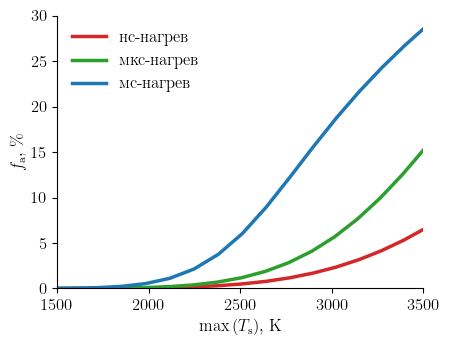

In [11]:
fig, ax = plt.subplots(figsize=(120 * mm2inch, 90 * mm2inch))

durations = ["ns", "us", "ms"]
titles = ["Наносекундный нагрев", "Микросекундный нагрев", "Миллисекундный нагрев"]
E_maxs = [10.2e3, 160e3, 3.8e6]
mat = "W"
phi = 1
eta_tr = 1e-2
E_dt = 1.5

colors = ["tab:red", "tab:green", "tab:blue"]
labels = ["нс-нагрев", "мкс-нагрев", "мс-нагрев"]
for i in range(3):

    E = E_maxs[i] * np.linspace(0, 1, 26, endpoint=True)

    fa = np.zeros_like(E)
    Tmax = np.zeros_like(E)

    for j in range(3, 26):
        # my_model = LID_simulation(E[j], durations[i], mat, E_dt, eta_tr, phi, "./results2", is_txt=False)

        filename_flux = (
            path
            + f"Atomic_fraction/results/fluxes_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
        )
        filename_data = (
            path
            + f"Atomic_fraction/results/data_{mat}_{durations[i]}_E{E[j]/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}.csv"
        )
        fluxes = np.loadtxt(fname=filename_flux, skiprows=0, delimiter=",")
        results = np.loadtxt(fname=filename_data, skiprows=1, delimiter=",")

        T = results[:, 3]

        t = fluxes[:, 0]
        Jat = fluxes[:, 1]
        J_mol_s = fluxes[:, 2]
        J_mol_sb = fluxes[:, 3]
        J_mol_b = fluxes[:, 4]
        J_des = fluxes[:, 5]

        N_a = np.trapz(Jat, x=t)
        N_des = np.trapz(J_des, x=t)

        if N_a < 1e10:
            fa[j] = 0
        else:
            fa[j] = N_a / N_des * 100

        Tmax[j] = T.max()

    ax.plot(Tmax, fa, label=labels[i], color=colors[i], lw=2.5)

ax.set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")
ax.set_ylabel(r"$f_\mathrm{a}$, \%")
ax.set_xlim(1500, 3500)
ax.set_ylim(0, 30)
ax.legend()
plt.savefig(
    "../../../Thesis/images/LID_atomic_fraction.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Impact of thermal conductivity

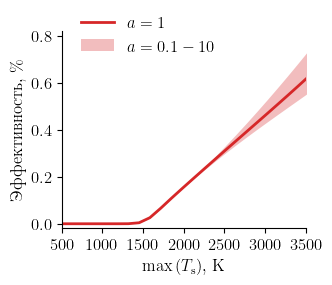

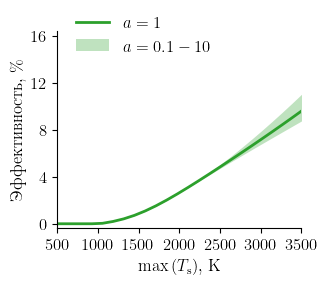

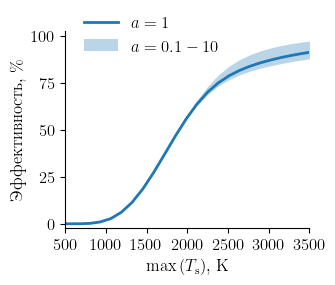

In [12]:
mat = "W"
durs = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.25, 1.5, 1.75, 2.0]
E_dt = 1.5

eta_trs = [1e-4, 1e-3, 1e-2, 1e-1]
eta_tr = 1e-2

phis = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
phi = 1

alphas = [0.1, 0.5, 1.00, 5, 10]
alpha = 1


def integrate_flux(t, F):
    return np.trapz(F, x=t)


for i in range(3):
    fig, ax = plt.subplots(figsize=(80 * mm2inch, 65 * mm2inch))
    all_T = []
    all_N_des = []
    for alpha in alphas:
        N_des = np.zeros(25)
        T_max = np.zeros(25)
        for j in range(1, 26):
            E = E_maxs[i] * j / 25 * np.sqrt(alpha)

            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}_alpha{alpha:.2f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_kappa_T/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path
                + "Properties_effect/results_kappa_T/data_"
                + name_pattern
                + ".csv",
                delimiter=",",
                skiprows=1,
            )

            T_max[j - 1] = data[:, 3].max()

            N_des[j - 1] = (
                integrate_flux(fluxes[:, 0], fluxes[:, -1])
                / (10e-6 * eta_tr * 6.31e28)
                * 100
            )

        all_T.append(T_max)
        all_N_des.append(N_des)

    ax.plot(all_T[2], all_N_des[2], color=colors[i], lw=2, label=r"$a=1$")

    maxs = get_maxs(all_N_des)
    mins = get_mins(all_N_des)
    ax.fill_between(
        all_T[0],
        mins,
        maxs,
        linewidth=0,
        alpha=0.3,
        color=colors[i],
        label=r"$a=0.1-10$",
    )

    ax.legend(loc=(0.05, 0.85))
    ax.set_xlim(500, 3500)
    if i == 0:
        ax.set_ylim(0 - 0.025 * 0.8, 0.8 + 0.025 * 0.8)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    elif i == 1:
        ax.set_ylim(0 - 0.025 * 16, 16 + 0.025 * 16)
        ax.set_yticks([0, 4, 8, 12, 16])
    else:
        ax.set_ylim(0 - 0.025 * 100, 100 + 0.025 * 100)
        ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_xticks([500, 1000, 1500, 2000, 2500, 3000, 3500])
    ax.set_ylabel(r"Эффективность, \%")
    ax.set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")
    plt.savefig(
        f"../../../Thesis/images/LID_kappa_var_{i}.pdf",
        bbox_inches="tight",
        pad_inches=0.02,
    )
plt.show()

## Impact of trap concentration and detrapping energy

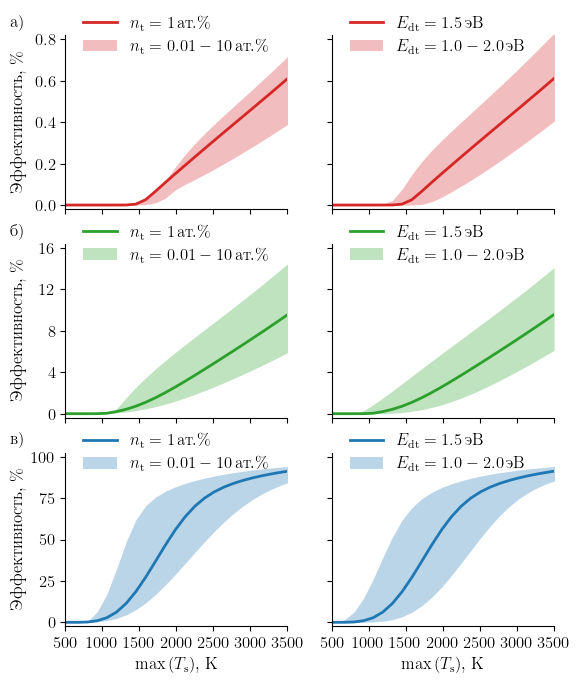

In [13]:
mat = "W"
durs = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.25, 1.5, 1.75, 2.0]
E_dt = 1.5

eta_trs = [1e-4, 1e-3, 1e-2, 1e-1]
eta_tr = 1e-2

phis = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
phi = 1


def integrate_flux(t, F):
    return np.trapz(F, x=t)


def get_maxs(data):
    data = np.array(data)
    maxs = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        maxs[i] = data[:, i].max()
    return maxs


def get_mins(data):
    data = np.array(data)
    mins = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        mins[i] = data[:, i].min()
    return mins


fig, ax = plt.subplots(
    3, 2, figsize=(160 * mm2inch, 65 * 3 * mm2inch), sharey="row", sharex=True
)
colors = ["tab:red", "tab:green", "tab:blue"]
for i in range(3):

    all_T = []
    all_N_des = []
    for eta_tr in eta_trs:
        N_des = np.zeros(25)
        T_max = np.zeros(25)
        for j in range(1, 26):
            E = E_maxs[i] * j / 25

            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_eta_T/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path + "Properties_effect/results_eta_T/data_" + name_pattern + ".csv",
                delimiter=",",
                skiprows=1,
            )

            T_max[j - 1] = data[:, 3].max()

            N_des[j - 1] = (
                integrate_flux(fluxes[:, 0], fluxes[:, 1] + fluxes[:, 2])
                / (10e-6 * eta_tr * 6.31e28)
                * 100
            )

        all_T.append(T_max)
        all_N_des.append(N_des)

    ax[i, 0].plot(
        all_T[2], all_N_des[2], color=colors[i], label=r"$n_\mathrm{t}=1\,$ат.\%", lw=2
    )

    maxs = get_maxs(all_N_des)
    mins = get_mins(all_N_des)
    ax[i, 0].fill_between(
        all_T[0],
        mins,
        maxs,
        linewidth=0,
        alpha=0.3,
        color=colors[i],
        label=r"$n_\mathrm{t}=0.01 - 10\,$ат.\%",
    )

    ax[i, 0].legend(loc=(0.05, 0.85))
    ax[i, 0].set_xlim(500, 3500)
    if i == 0:
        ax[i, 0].set_ylim(0 - 0.025 * 0.8, 0.8 + 0.025 * 0.8)
        ax[i, 0].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    elif i == 1:
        ax[i, 0].set_ylim(0 - 0.025 * 16, 16 + 0.025 * 16)
        ax[i, 0].set_yticks([0, 4, 8, 12, 16])
    else:
        ax[i, 0].set_ylim(0 - 0.025 * 100, 100 + 0.025 * 100)
        ax[i, 0].set_yticks([0, 25, 50, 75, 100])
        ax[i, 0].set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")
    ax[i, 0].set_xticks([500, 1000, 1500, 2000, 2500, 3000, 3500])
    ax[i, 0].set_ylabel(r"Эффективность, \%")

eta_tr = 1e-2
for i in range(3):
    all_T = []
    all_N_des = []
    for E_dt in E_dts:
        N_des = np.zeros(25)
        T_max = np.zeros(25)
        for j in range(1, 26):
            E = E_maxs[i] * j / 25

            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_Edt_T/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path + "Properties_effect/results_Edt_T/data_" + name_pattern + ".csv",
                delimiter=",",
                skiprows=1,
            )

            T_max[j - 1] = data[:, 3].max()

            N_des[j - 1] = (
                integrate_flux(fluxes[:, 0], fluxes[:, 1] + fluxes[:, 2])
                / (10e-6 * 1e-2 * 6.31e28)
                * 100
            )

        all_T.append(T_max)
        all_N_des.append(N_des)
        if i == 2:
            ax[i, 1].set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")

    ax[i, 1].plot(
        all_T[2], all_N_des[2], color=colors[i], lw=2, label=r"$E_\mathrm{dt}=1.5\,$эВ"
    )
    ax[i, 1].fill_between(
        all_T[0],
        all_N_des[0],
        all_N_des[-1],
        linewidth=0,
        alpha=0.3,
        color=colors[i],
        label=r"$E_\mathrm{dt}=1.0-2.0\,$эВ",
    )
    ax[i, 1].legend(loc=(0.05, 0.85))

letters = ["а)", "б)", "в)"]
for i, let in enumerate(letters):
    ax[i, 0].text(-0.25, 1.05, let, transform=ax[i, 0].transAxes, fontweight="bold")

fig.align_ylabels()
plt.savefig(
    f"../../../Thesis/images/LID_n_Edt_var.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Population

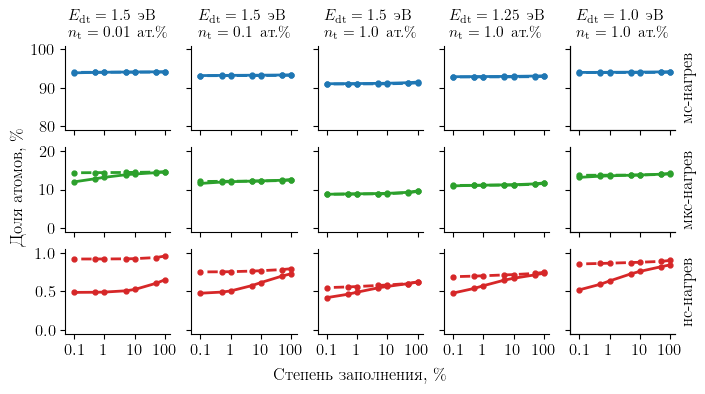

In [14]:
colors = ["tab:red", "tab:green", "tab:blue"]
mat = "W"
durs = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
E_dts = [1.0, 1.25, 1.5, 1.75, 2.0]
E_dt = 1.5

eta_trs = [1e-4, 1e-3, 1e-2, 1e-1]
eta_tr = 1e-2

phis = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
phi = 1

alphas = [0.5, 0.75, 1.00, 1.25, 1.50]
alpha = 1

fig, axs = plt.subplots(
    3, len(alphas), figsize=(200 * mm2inch, 95 * mm2inch), sharex=True, sharey="row"
)


def integrate_flux(t, F):
    return np.trapz(F, x=t)


def get_maxs(data):
    data = np.array(data)
    maxs = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        maxs[i] = data[:, i].max()
    return maxs


def get_mins(data):
    data = np.array(data)
    mins = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        mins[i] = data[:, i].min()
    return mins


kwargs = {"marker": "o", "ms": 3.5, "lw": 2}

for i in range(3):
    all_T = []
    all_N_des = []

    E_dt = 1.5
    for j, eta_tr in enumerate(eta_trs[0:3]):
        E = E_maxs[i]
        N_des = np.zeros(len(phis))
        N_dif = np.zeros(len(phis))
        for k, phi in enumerate(phis):
            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_eta_phi/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path
                + "Properties_effect/results_eta_phi/data_"
                + name_pattern
                + ".csv",
                delimiter=",",
                skiprows=1,
            )

            N_des[k] = (
                integrate_flux(fluxes[:, 0], fluxes[:, -1])
                / (10e-6 * eta_tr * phi * 6.31e28)
                * 100
            )
            N_dif[k] = (
                integrate_flux(data[:, 0], -data[:, 2])
                / (10e-6 * eta_tr * phi * 6.31e28)
                * 100
            )

        axs[2 - i, j].plot(np.array(phis) * 100, N_des, color=colors[i], **kwargs)
        axs[2 - i, j].plot(
            np.array(phis) * 100, N_dif, color=colors[i], ls="dashed", **kwargs
        )

        if i == 2:
            axs[2 - i, j].set_title(
                rf"$E_\mathrm{{dt}}={E_dt}\,$ эВ\\\indent$n_\mathrm{{t}}={eta_tr/1e-2}\,$ ат.\%",
                fontsize=11,
                y=1.2,
            )

    eta_tr = 1e-2
    for j, E_dt in enumerate(E_dts[-4:-6:-1]):
        E = E_maxs[i]
        N_des = np.zeros(len(phis))
        N_dif = np.zeros(len(phis))
        for k, phi in enumerate(phis):
            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_Edt_phi/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path
                + "Properties_effect/results_Edt_phi/data_"
                + name_pattern
                + ".csv",
                delimiter=",",
                skiprows=1,
            )

            N_des[k] = (
                integrate_flux(fluxes[:, 0], fluxes[:, -1])
                / (10e-6 * eta_tr * phi * 6.31e28)
                * 100
            )
            N_dif[k] = (
                integrate_flux(data[:, 0], -data[:, 2])
                / (10e-6 * eta_tr * phi * 6.31e28)
                * 100
            )

        axs[2 - i, j + 3].plot(np.array(phis) * 100, N_des, color=colors[i], **kwargs)
        axs[2 - i, j + 3].plot(
            np.array(phis) * 100, N_dif, color=colors[i], ls="dashed", **kwargs
        )

        if i == 2:
            axs[2 - i, j + 3].set_title(
                rf"$E_\mathrm{{dt}}={E_dt}\,$ эВ\\\indent$n_\mathrm{{t}}={eta_tr/1e-2}\,$ ат.\%",
                fontsize=11,
                y=1.2,
            )

axs[0, 0].set_xscale("log")
axs[0, 0].set_xticks([0.1, 1, 10, 100])
axs[0, 0].set_xlim(0.05, 150)
axs[0, 0].set_xticklabels(["0.1", "1", "10", "100"])
axs[2, 0].set_ylim(-0.05, 1.05)
axs[1, 0].set_ylim(0 - 20 * 0.05, 20 + 20 * 0.05)
axs[0, 0].set_ylim(80 - 20 * 0.05, 100 + 20 * 0.05)
axs[0, 0].set_yticks([80, 90, 100])
axs[1, 0].set_yticks([0, 10, 20])
axs[2, 0].set_yticks([0, 0.5, 1.0])
fig.supylabel(r"Доля атомов, \%", fontsize=12, x=0.055)
fig.supxlabel(r"Степень заполнения, \%", fontsize=12, y=-0.025)

durs = ["мс", "мкс", "нс"]
for i in range(3):
    ax2 = axs[i, 4].twinx()
    ax2.set_yticks([])
    ax2.set_ylabel(durs[i] + "-нагрев")

plt.savefig(
    f"../../../Thesis/images/LID_Edt_n_pop.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## LID regimes

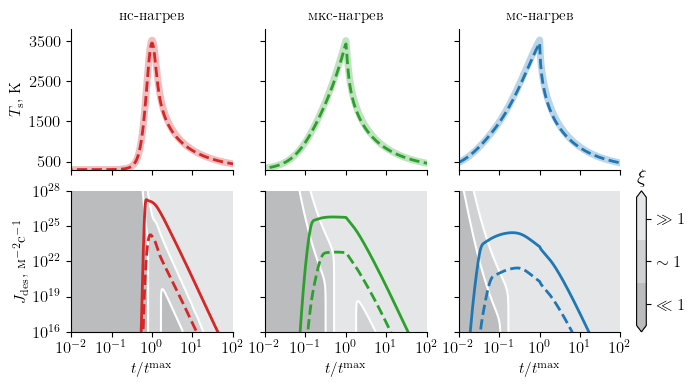

In [15]:
from scipy.integrate import quad
from sub_functions.materials import W
from festim import k_B
from scipy.special import dawsn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as m_colors
import mpmath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mpmath.mp.dps = 15

M = 183.84e-3
heat_cap = (
    lambda T: (
        21.868372
        + 8.068661e-3 * T
        - 3.756196e-6 * T**2
        + 1.075862e-9 * T**3
        + 1.406637e4 / (T + 1.0) ** 2
    )
    / M
)

therm_cond = (
    lambda T: 149.441
    - 45.466e-3 * T
    + 13.193e-6 * T**2
    - 1.484e-9 * T**3
    + 3.866e6 / (T + 1.0) ** 2
)

kappa = therm_cond(1500)
rho = 19250
Cp = heat_cap(1500)
T0 = 300

E_dt = 1.5
n_t = 1e-2

mat = W()


def D(z):
    exponent = mpmath.exp(-(z**2) / 4)
    parabolic_cyl = mpmath.pcfd(-0.5, -z)  # D_{-1/2}(-z)
    return exponent * parabolic_cyl


def gauss_temp(t, E0, t0, FWHM):
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
    z = (t - t0) / sigma
    D_exp_values = np.float128(D(z))

    return E0 / np.sqrt(2 * np.pi * sigma * Cp * rho * kappa) * D_exp_values + T0


def trap_temp(t, E0, t1, t2, delta, tau_le, tau_te):
    w1 = lambda t: 1 - np.exp(-t / tau_le)
    w2 = lambda t: w1(t1) * (1 + delta * (t - t1) / (t2 - t1))
    tau = (
        t1
        + tau_le * (np.exp(-t1 / tau_le) - 1)
        + w1(t1) * (t2 - t1) * (1 + delta / 2)
        + w2(t2) * tau_te
    )

    h1 = lambda t: np.sqrt(t / tau) - np.sqrt(tau_le / tau) * dawsn(np.sqrt(t / tau_le))
    h2 = (
        lambda t: h1(t)
        + np.sqrt(tau_le / tau)
        * np.exp(-t1 / tau_le)
        * dawsn(np.sqrt((t - t1) / tau_le))
        + np.sqrt((t - t1) / tau)
        * (w1(t1) * (1 + 2 * delta / 3 * (t - t1) / (t2 - t1)) - 1)
    )
    h3 = (
        lambda t: h2(t)
        + w2(t2) * np.sqrt(tau_te / tau) * dawsn(np.sqrt((t - t2) / tau_te))
        - w1(t1)
        * np.sqrt((t - t2) / tau)
        * (delta / 3 * (1 + 2 * (t - t1) / (t2 - t1)) + 1)
    )

    shape = lambda t: np.piecewise(
        t,
        [t <= t1, (t > t1) & (t <= t2), t > t2],
        [lambda t: h1(t), lambda t: h2(t), lambda t: h3(t)],
    )
    return 2 * E0 / np.sqrt(tau * np.pi * kappa * Cp * rho) * shape(t) + T0


def D_eff(t, T_func):
    T = T_func(t)
    return (
        mat.D_0
        * np.exp(-mat.E_diff / k_B / T)
        / (1 + n_t * mat.nu_D / mat.nu_0 * np.exp(-(mat.E_diff - E_dt) / k_B / T))
    )


def delta_eff(t, T_func):
    return np.sqrt(quad(D_eff, 0, t, args=T_func)[0])


def tau_D(t, T_func):
    return delta_eff(t, T_func) ** 2 / D_eff(t, T_func)


def nu_des(F, T):
    nu_a = mat.nu_0 * np.exp(-(mat.E_d - mat.Q_c(0)) / k_B / T)
    nu_mol = mat.nu_0 / mat.n_surf * np.exp(-2 * (mat.E_c - mat.Q_c(0)) / k_B / T)
    return nu_a / 2 * (1 + np.sqrt(1 + 8 * F * nu_mol / nu_a**2))


fluxes = np.geomspace(1e16, 1e28, num=500)

temp_funcs = [
    lambda t: gauss_temp(t, 10.2e3, 40e-9, 25e-9),
    lambda t: trap_temp(t, 160e3, *us_params),
    lambda t: trap_temp(t, 3.8e6, *ms_params),
]

colors_list = [
    (187 / 255, 188 / 255, 190 / 255),
    (187 / 255, 188 / 255, 190 / 255),
    (208 / 255, 209 / 255, 211 / 255),
    (208 / 255, 209 / 255, 211 / 255),
    (229 / 255, 230 / 255, 231 / 255),
    (229 / 255, 230 / 255, 231 / 255),
]

units_times = [1e-9, 1e-6, 1e-3]
sigma = 25e-9 / (2 * np.sqrt(2 * np.log(2)))
us_params = [2.5e-6, 9.5e-6, 0, 0.5e-6, 0.5e-6]
ms_params = [0.25e-3, 4.95e-3, -0.3, 0.05e-3, 0.05e-3]

t_maxs = [40e-9 + 0.765 * sigma, us_params[1], ms_params[1]]

line_colors = ["tab:red", "tab:green", "tab:blue"]
titles = ["нс-нагрев", "мкс-нагрев", "мс-нагрев"]
fig, axs = plt.subplots(
    2, 3, figsize=(180 * mm2inch, 100 * mm2inch), sharex=True, sharey="row"
)

for i, T_func in enumerate(temp_funcs):
    times = np.geomspace(1e-2, 1e4, num=500) * units_times[i]
    ksi = np.zeros((len(times), len(fluxes)))
    taus_D = np.zeros_like(times)
    temps = np.zeros_like(times)

    for j, t in enumerate(times):
        taus_D[j] = tau_D(t, T_func)
        temps[j] = T_func(t)

    axs[0, i].plot(times / t_maxs[i], temps, color=line_colors[i], lw=2, ls="dashed")
    axs[0, i].set_title(titles[i], fontsize=11)

    for j, t in enumerate(times):
        for k, f in enumerate(fluxes):
            t_D = taus_D[j]
            n_des = nu_des(f, temps[j])
            ksi[j][k] = t_D * n_des

    cf = axs[1, i].contourf(
        times / t_maxs[i],
        fluxes,
        ksi.transpose(),
        cmap=m_colors.ListedColormap(colors_list),
        vmin=0.1,
        vmax=10,
        levels=[0.01, 0.1, 10, 100],
        extend="both",
    )
    axs[1, i].contour(
        times / t_maxs[i], fluxes, ksi.transpose(), colors="white", levels=[0.1, 10]
    )

    axs[1, i].set_xlabel(r"$t/t^\mathrm{max}$", fontsize=11)

axins = inset_axes(
    axs[1, 2],
    width="6%",  # width: 5% of parent_bbox width
    height="100%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.1, 0.0, 1, 1),
    bbox_transform=axs[1, 2].transAxes,
    borderpad=0,
)
cbar = fig.colorbar(cf, cax=axins, ticks=[0.055, 5.05, 55], pad=0.01, aspect=15)
cbar.ax.set_yticklabels([r"$\ll 1$", r"$\sim 1$", r"$\gg 1$"])
cbar.ax.set_title(r"$\mathrm{\xi}$")

phis = [1, 1e-3]
mat = "W"
durations = ["ns", "us", "ms"]
E_maxs = [10.2e3, 160e3, 3.8e6]
line_styles = ["solid", "dashed"]
for i, dur in enumerate(durations):

    E = E_maxs[i]
    filename_data = path+f"Properties_effect/results_LID_regimes/data_{mat}_{dur}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(n_t):.5f}.csv"
    results = np.loadtxt(fname=filename_data, skiprows=1, delimiter=",")
    t = np.array(results[:, 0])
    T = np.array(results[:, -2])
    axs[0, i].plot(t / t_maxs[i], T, color=line_colors[i], lw=5, ls="solid", alpha=0.3)

    for j, phi in enumerate(phis):
        filename_fluxes = path+f"Properties_effect/results_LID_regimes/fluxes_{mat}_{dur}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(n_t):.5f}_phi{-np.log10(phi):.5f}.csv"
        results = np.loadtxt(fname=filename_fluxes, skiprows=1, delimiter=",")

        t = np.array(results[:, 0])
        des = np.array(results[:, -1])
        axs[1, i].plot(
            t / t_maxs[i], des, color=line_colors[i], lw=2, ls=line_styles[j]
        )

axs[1, 0].set_yscale("log")
axs[1, 0].set_xscale("log")
axs[0, 0].set_xlim(1e-2, 1e2)
axs[0, 0].set_ylabel(r"$T_\mathrm{s}$, К", fontsize=11)
axs[1, 0].set_ylabel(r"$J_\mathrm{des}$, м$^{-2}$с$^{-1}$", fontsize=11)
axs[1, 0].set_yticks([1e-2, 1e-1, 1, 1e1, 1e2])
axs[0, 0].set_yticks([500, 1500, 2500, 3500])
axs[0, 0].set_ylim(300, 3800)
axs[1, 0].set_yticks([1e16, 1e19, 1e22, 1e25, 1e28])
axs[1, 0].set_ylim(1e16, 1e28)
axs[0, 0].set_xticks([1e-2, 1e-1, 1, 10, 100])

plt.subplots_adjust(hspace=0.15)
plt.savefig(
    f"../../../Thesis/images/LID_regimes.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()

## Specific simulations for LID regimes figure

In [16]:
from model import LID_simulation
import numpy as np


E_dt = 1.5
eta_tr = 1e-2
phis = [1e-3]
mat = "W"
durations = ["ms"]
E_maxs = [3.8e6]

mat = "W"
output = ("./results_LID_regimes",)

for i, dur in enumerate(durations):
    for phi in phis:
        E = E_maxs[i]
        model = LID_simulation(
            E,
            dur,
            mat,
            E_dt,
            eta_tr,
            phi,
            "./results_LID_regimes",
            is_txt=False,
            soret=True,
        )

        results = model.run()

        t = np.array(results.t)
        cs = np.array(results[0].data)
        T = np.array(results[2].data)
        cm = np.array(results[3].data)

        Jat = model.J_a(T, cs)
        Jmol_s = model.J_m_s(T, cs)
        J_mol_sb = 2 * model.J_m_sb(T, cs, cm)
        J_mol_b = model.J_m_b(T, cm)

        J_des = Jat + Jmol_s + J_mol_b + J_mol_sb

        out = np.column_stack([t, Jat, Jmol_s, J_mol_sb, J_mol_b, J_des])

        filename = f"./results_LID_regimes/fluxes_{mat}_{dur}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}.csv"
        np.savetxt(filename, out, delimiter=",")

'from model import LID_simulation\nimport numpy as np\n\n\nE_dt = 1.5\neta_tr = 1e-2\nphis = [1e-3]\nmat = "W"\ndurations = ["ms"]\nE_maxs = [3.8e6]\n\nmat = "W"\noutput = ("./results_LID_regimes",)\n\nfor i, dur in enumerate(durations):\n    for phi in phis:\n        E = E_maxs[i]\n        model = LID_simulation(\n            E,\n            dur,\n            mat,\n            E_dt,\n            eta_tr,\n            phi,\n            "./results_LID_regimes",\n            is_txt=False,\n            soret=True,\n        )\n\n        results = model.run()\n\n        t = np.array(results.t)\n        cs = np.array(results[0].data)\n        T = np.array(results[2].data)\n        cm = np.array(results[3].data)\n\n        Jat = model.J_a(T, cs)\n        Jmol_s = model.J_m_s(T, cs)\n        J_mol_sb = 2 * model.J_m_sb(T, cs, cm)\n        J_mol_b = model.J_m_b(T, cm)\n\n        J_des = Jat + Jmol_s + J_mol_b + J_mol_sb\n\n        out = np.column_stack([t, Jat, Jmol_s, J_mol_sb, J_mol_b, J_des])

## Synopsis

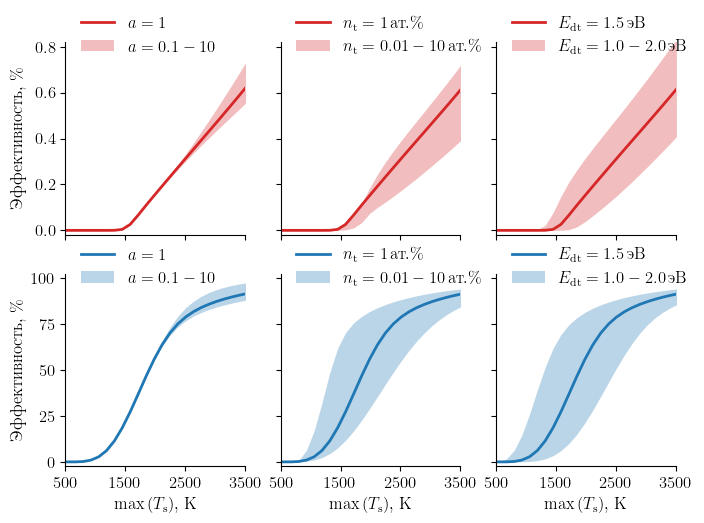

In [17]:
mat = "W"
durs = ["ns", "ms"]
E_maxs = [10.2e3, 3.8e6]
E_dts = [1.0, 1.25, 1.5, 1.75, 2.0]
E_dt = 1.5

eta_trs = [1e-4, 1e-3, 1e-2, 1e-1]
eta_tr = 1e-2

phis = [1, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3]
phi = 1


def integrate_flux(t, F):
    return np.trapz(F, x=t)


def get_maxs(data):
    data = np.array(data)
    maxs = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        maxs[i] = data[:, i].max()
    return maxs


def get_mins(data):
    data = np.array(data)
    mins = np.zeros(len(data[0]))
    for i, l1 in enumerate(data[0]):
        mins[i] = data[:, i].min()
    return mins

alphas = [0.1, 0.5, 1.00, 5, 10]
alpha = 1

fig, ax = plt.subplots(
    2, 3, figsize=(200 * mm2inch, 140 * mm2inch), sharey="row", sharex=True
)
colors = ["tab:red", "tab:blue"]

for i in range(2):
    all_T = []
    all_N_des = []
    for alpha in alphas:
        N_des = np.zeros(25)
        T_max = np.zeros(25)
        for j in range(1, 26):
            E = E_maxs[i] * j / 25 * np.sqrt(alpha)

            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}_alpha{alpha:.2f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_kappa_T/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path
                + "Properties_effect/results_kappa_T/data_"
                + name_pattern
                + ".csv",
                delimiter=",",
                skiprows=1,
            )

            T_max[j - 1] = data[:, 3].max()

            N_des[j - 1] = (
                integrate_flux(fluxes[:, 0], fluxes[:, -1])
                / (10e-6 * eta_tr * 6.31e28)
                * 100
            )

        all_T.append(T_max)
        all_N_des.append(N_des)

    ax[i][0].plot(all_T[2], all_N_des[2], color=colors[i], lw=2, label=r"$a=1$")

    maxs = get_maxs(all_N_des)
    mins = get_mins(all_N_des)
    ax[i][0].fill_between(
        all_T[0],
        mins,
        maxs,
        linewidth=0,
        alpha=0.3,
        color=colors[i],
        label=r"$a=0.1-10$",
    )

    ax[i][0].legend(loc=(0.05, 0.9))
    ax[i][0].set_xlim(500, 3500)
    if i == 0:
        ax[i][0].set_ylim(0 - 0.025 * 0.8, 0.8 + 0.025 * 0.8)
        ax[i][0].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    else:
        ax[i][0].set_ylim(0 - 0.025 * 100, 100 + 0.025 * 100)
        ax[i][0].set_yticks([0, 25, 50, 75, 100])
        ax[i][0].set_xticks([500, 1500, 2500, 3500])
        ax[i][0].set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")
    ax[i][0].set_ylabel(r"Эффективность, \%")

for i in range(2):

    all_T = []
    all_N_des = []
    for eta_tr in eta_trs:
        N_des = np.zeros(25)
        T_max = np.zeros(25)
        for j in range(1, 26):
            E = E_maxs[i] * j / 25

            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_eta_T/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path + "Properties_effect/results_eta_T/data_" + name_pattern + ".csv",
                delimiter=",",
                skiprows=1,
            )

            T_max[j - 1] = data[:, 3].max()

            N_des[j - 1] = (
                integrate_flux(fluxes[:, 0], fluxes[:, 1] + fluxes[:, 2])
                / (10e-6 * eta_tr * 6.31e28)
                * 100
            )

        all_T.append(T_max)
        all_N_des.append(N_des)

    ax[i, 1].plot(
        all_T[2], all_N_des[2], color=colors[i], label=r"$n_\mathrm{t}=1\,$ат.\%", lw=2
    )

    maxs = get_maxs(all_N_des)
    mins = get_mins(all_N_des)
    ax[i, 1].fill_between(
        all_T[0],
        mins,
        maxs,
        linewidth=0,
        alpha=0.3,
        color=colors[i],
        label=r"$n_\mathrm{t}=0.01 - 10\,$ат.\%",
    )

    ax[i, 1].legend(loc=(0.05, 0.9))
    ax[i, 1].set_xlim(500, 3500)
    if i == 0:
        ax[i, 1].set_ylim(0 - 0.025 * 0.8, 0.8 + 0.025 * 0.8)
        ax[i, 1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    else:
        ax[i, 1].set_ylim(0 - 0.025 * 100, 100 + 0.025 * 100)
        ax[i, 1].set_yticks([0, 25, 50, 75, 100])
        ax[i, 1].set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")

eta_tr = 1e-2
for i in range(2):
    all_T = []
    all_N_des = []
    for E_dt in E_dts:
        N_des = np.zeros(25)
        T_max = np.zeros(25)
        for j in range(1, 26):
            E = E_maxs[i] * j / 25

            name_pattern = f"{mat}_{durs[i]}_E{E/1e6:.5f}MJ_Edt{E_dt:.5f}eV_eta{-np.log10(eta_tr):.5f}_phi{-np.log10(phi):.5f}"

            fluxes = np.loadtxt(
                path
                + "Properties_effect/results_Edt_T/fluxes_"
                + name_pattern
                + ".csv",
                delimiter=",",
            )
            data = np.loadtxt(
                path + "Properties_effect/results_Edt_T/data_" + name_pattern + ".csv",
                delimiter=",",
                skiprows=1,
            )

            T_max[j - 1] = data[:, 3].max()

            N_des[j - 1] = (
                integrate_flux(fluxes[:, 0], fluxes[:, 1] + fluxes[:, 2])
                / (10e-6 * 1e-2 * 6.31e28)
                * 100
            )

        all_T.append(T_max)
        all_N_des.append(N_des)
        if i == 1:
            ax[i, 2].set_xlabel(r"$\max\left(T_\mathrm{s}\right)$, K")

    ax[i, 2].plot(
        all_T[2], all_N_des[2], color=colors[i], lw=2, label=r"$E_\mathrm{dt}=1.5\,$эВ"
    )
    ax[i, 2].fill_between(
        all_T[0],
        all_N_des[0],
        all_N_des[-1],
        linewidth=0,
        alpha=0.3,
        color=colors[i],
        label=r"$E_\mathrm{dt}=1.0-2.0\,$эВ",
    )
    ax[i, 2].legend(loc=(0.05, 0.9))

fig.align_ylabels()
plt.savefig(
    f"../../../Thesis/images/LID_kappa_n_Edt_var.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
)
plt.show()